# Sentence Ordering

* Author: Ali Akbar Halvaei 
* email: ali.akbarhalvaei@studio.unibo.it

**Description**:
In this notebook, we want to design one RNN encoder-decoder with the aim of ordering unordered sentences. So, there are three main steps in this notebook:

* Downloading the dataset
* Preparing the dataset
* Design the model

For this task, transformers have better performance; however, with the purpose of learning about how RNN encoder-decoder works, I have decided to design this model


This task is among the sequence-to-sequence task. Recently, most of the task in this category have been done using by either Transformers or Encoder-Decoder architecture. 

In [ ]:
!pip install datasets

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
import re

np.random.seed(42)

# Load dataset
ds = load_dataset('generics_kb', trust_remote_code=True)['train']

# Filter sentences longer than 8 words
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8)

# Prepare corpus with special tokens
corpus = ['<start> ' + row['generic_sentence'].replace(",", " <comma>") + ' <end>' for row in ds]
corpus = np.array(corpus)

# Define TextVectorization
tokenizer = TextVectorization(max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8")
tokenizer.adapt(corpus)

# Define the TextDetokenizer class
class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
            if t == 3:
                return "<start>"
            elif t == 2:
                return "<end>"
            elif t == 7:
                return "<comma>"
            else:
                return self.index_to_word.get(t, '[UNK]')

        return ' '.join([check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
        return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

# Initialize the detokenizer
detokenizer = TextDetokenizer(tokenizer)

# Tokenize the corpus
sentences = tokenizer(corpus).numpy()

# Filter out sentences with unknown tokens
mask = np.sum((sentences == 1), axis=1) >= 1
original_data = np.delete(sentences, mask, axis=0)

2024-06-12 01:08:24.890022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 01:08:24.890117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 01:08:25.021734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

In [3]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

# Shuffle and split the dataset into training and test sets
np.random.seed(42)
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

train_data = shuffled_data[:220000]
test_data = shuffled_data[220000:]
test_generator = DataGenerator(test_data, batch_size=32)
train_generator = DataGenerator(train_data, batch_size=64)


In [ ]:
train_generator = DataGenerator(original_data[:220000])
test_generator = DataGenerator(original_data[220000:])
x, y = test_generator.__getitem__(1)

In [5]:
a = detokenizer(x)
b = detokenizer(y)

for i in range(7):
    print("original: ", b[i])
    print("shuffled: ", a[i])
    print("\n")

original:  <start> wind energy is the one of the most inexpensive forms of energy on the market <end>
shuffled:  <start> the on is the wind of forms market energy of energy inexpensive most the one <end>


original:  <start> tropical rainforests contain many diverse species <comma> many of which are found nowhere else <end>
shuffled:  <start> species tropical are else many nowhere many rainforests of contain found which <comma> diverse <end>


original:  <start> urban environments differ from agricultural and wild lands in many respects <end>
shuffled:  <start> urban in and wild lands environments respects many from agricultural differ <end>


original:  <start> water conservation is one important way to stretch existing water supplies <end>
shuffled:  <start> water supplies to conservation water stretch is important way existing one <end>


original:  <start> urban life is concentrated in the capital <comma> whose population is mostly engaged in commerce <end>
shuffled:  <start> is in

# **Data preparation**

When it comes to using Encoder-Decoder structures, we are dealing with 3 data for the model:

1. Encoder input
2. Decoder input
3. Decoder target

In our task, encoder input is the shuffled data, and decoder input and output are the ordered data with a little difference.
For Encoder input, the data does not include our special words: **'start', 'end'**

On the other hand, The decoder input contain **'start'** but does not contain **'end'**. The reason behind is that after training the model, we receive encoder input and based on the context data(provided by the encoder), we predict decoder values token by token.

Finally, Decoder output does not contain **'start'** but contains **'end'**. 



In [102]:
BATCH_SIZE = 32
MAX_LENGTH = 28


tds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, MAX_LENGTH), dtype=tf.int32), 
        tf.TensorSpec(shape=(BATCH_SIZE, MAX_LENGTH), dtype=tf.int32)   
    )
)


test_tds = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, MAX_LENGTH), dtype=tf.int32),  
        tf.TensorSpec(shape=(BATCH_SIZE, MAX_LENGTH), dtype=tf.int32)   
    )
)

Why I loaded data into train and test generator and then I change their shape?


class DataGenerator has been given by the challenge provider, so I was not supposed to change it. However, I did not like to have data with specific batch size because I could not change the batch size during training phase to find the best batch size for myself. Thus, I have decided to load them into other arrays for training

In [103]:
enc = list()
dec = list()


for i, j in tds:
    enc.append(i)
    dec.append(j)



encoder_inputs_data = tf.convert_to_tensor(enc)
decoder_inputs_data = tf.convert_to_tensor(dec)
decoder_target_data = decoder_inputs_data


In [104]:
enc_test = []
dec_test = []

for i, j in test_tds:
    enc_test.append(i)
    dec_test.append(j)

In [105]:
#as mentioned encoder should not contain <start> and <end>, so this function removes those words from our encoder input data

def encoder_input_preparation(tensor, END_INDEX = 2):
    
    shifted_tensor = np.zeros_like(tensor)
    for i in range(tensor.shape[0]):
        # Shift elements to the left and drop the first element
        shifted_tensor[i, :-1] = tensor[i, 1:]
        # Replace 2 with 0
        shifted_tensor[i] = np.where(shifted_tensor[i] == END_INDEX, 0, shifted_tensor[i])
    return shifted_tensor


#decoder input data should not contain <end> and this function removes them for us
def decoder_input_preparation(tensor, END_INDEX = 2):
    tensor[i] = np.where(tensor[i] == END_INDEX , 0, tensor[i])
    
    return tensor

In [106]:
#as the given data is in the shape of 6875,32,28 , I did not have the freedome to change the batch_size to see the performance on different batch_sizes
#Thus, I decided to reshape them so that during training I can change different batch sizes
encoder_inputs_data = np.array(enc).reshape(220000, 28)
encoder_inputs_data = encoder_input_preparation(encoder_inputs_data)

decoder_inputs_data = np.array(dec).reshape(220000, 28)
decoder_inputs_data = decoder_input_preparation(decoder_inputs_data)
decoder_inputs_data = decoder_inputs_data[:, :-1]

decoder_output = np.array(dec).reshape(220000, 28)
decoder_output = decoder_output[:, 1:]
decoder_target_data = np.expand_dims(decoder_output, -1)

In [107]:
#This cell take care of preparing test data
encoder_inputs_data_test = np.array(enc_test).reshape(21216, 28)
encoder_inputs_data_test = encoder_input_preparation(encoder_inputs_data_test)

decoder_inputs_data_test = np.array(dec_test).reshape(21216, 28)
decoder_inputs_data_test = decoder_input_preparation(decoder_inputs_data_test)
decoder_inputs_data_test = decoder_inputs_data_test[:, :-1]

decoder_output_test = np.array(dec_test).reshape(21216, 28)
decoder_output_test = decoder_output_test[:, :-1]
#the reason that I exoanded decoder output dimension is based on the way encoder-decoder work
#in the inference part, decoder values are produced token by token, so we expand the dimension so that we will be able 
#to generate it token by token
decoder_output_test = np.expand_dims(decoder_output_test, -1)

In [108]:
#here we can se a sample of encoder input which does not have start(3) and end(2) indexes
encoder_inputs_data[0]

array([  47, 2756,  685,   21,   16, 6775,   11,   10,  224,  679, 6429,
        969,  114, 1112, 3941,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [109]:
#decoder input has start(3) index as it should 
decoder_inputs_data[0]

array([   3, 3941, 6775,  114,  685,   21, 6429,   16, 1112,  969,   47,
         10,  224,  679,   11, 2756,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [110]:
decoder_target_data[0]

array([[3941],
       [6775],
       [ 114],
       [ 685],
       [  21],
       [6429],
       [  16],
       [1112],
       [ 969],
       [  47],
       [  10],
       [ 224],
       [ 679],
       [  11],
       [2756],
       [   2],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0]], dtype=int32)

**Hyperparameters:**
* Reasonable value for embed_dim is either 128 or 256. However, when we choose 256, it increase the number of parameters significanlty(arround two times) but the result compared to the network with 128 embed_dim was almost the same. Hence, I have decided to choose 128 because the training time, testing time were significanlty better and almost the same result

* Loss is Sparse Categorical Cross Entroppy because our label are integers and they are not in the form of One-hot encoding. Thus, we cannot use Categorical Cross Entropy and we should use Sparse version.


* Optimizer is Adam, firstly because of the all works so far in seq2seq problems have used this optimizer and secondly, the results of this optimizer compared to RMSprop was better

In [111]:
vocab_size = tokenizer.vocabulary_size()
max_length = sentences.shape[1]
embed_dim = 128
lstm_units = 256
dropout_rate = 0.3

In [119]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model

def build_lstm_model(vocab_size, max_length, embed_dim=128, lstm_units=512, dropout_rate=0.2):
    # Encoder
    encoder_inputs = Input(shape=(max_length,), dtype='int32', name='encoder_inputs')
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_dropout=dropout_rate, use_cudnn=False)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    #Decoder input data is shifted. This is the reason of max_length - 1
    decoder_inputs = Input(shape=(max_length-1,), dtype='int32', name='decoder_inputs')
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length-1, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_dropout=dropout_rate, use_cudnn=False)
    #in decoder output in this architecture, the states of the LSTMs are not important and we do not use them.
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

vocab_size = 10000  # Update this according to your tokenizer
max_length = train_data.shape[1]  # Assuming all sequences have the same length
model = build_lstm_model(vocab_size, max_length = 28)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_40        │ (None, 28, 128)   │  1,280,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_50        │ (None, 28)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_41        │ (None, 27, 128)   │  1,280,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_66 (LSTM)      │ [(None, 28, 512), │  1,312,768 │ embedding_40[0][… │
│                     │ (None, 512),      │            │ not_equal_50[0][… │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_67 (LSTM)      │ [(None, 27, 512), │  1,312,768 │ embedding_41[0][… │
│                     │ (None, 512),      │            │ lstm_66[0][1],    │
│                     │ (None, 512)]      │            │ lstm_66[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_51        │ (None, 27)        │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 27, 10000) │  5,130,000 │ lstm_67[0][0],    │
│ (TimeDistributed)   │                   │            │ not_equal_51[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,315,536 (39.35 MB)

 Trainable params: 10,315,536 (39.35 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
batch_size = 32
epochs = 10

# Train the model
history = model.fit(
    [encoder_inputs_data, decoder_inputs_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 232s 32ms/step - loss: 4.7572
Epoch 2/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 2.1780
Epoch 3/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 1.2490
Epoch 4/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.8377
Epoch 5/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.6387
Epoch 6/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.5180
Epoch 7/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 262s 32ms/step - loss: 0.4369
Epoch 8/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.3800
Epoch 9/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.3359
Epoch 10/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 217s 32ms/step - loss: 0.3007


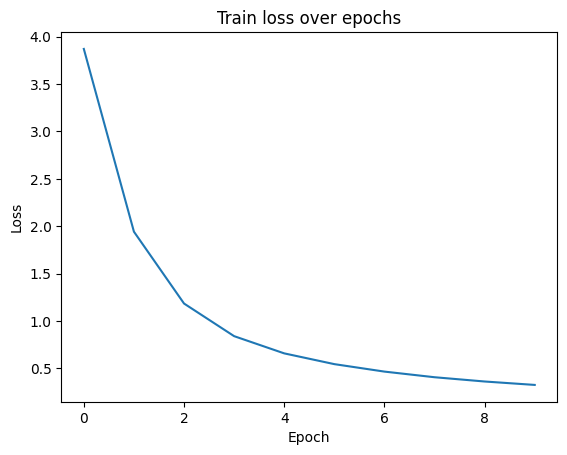

In [122]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss over epochs')
plt.show()

In [123]:
loss_10epoch = history.history['loss']

# Inference

**Why we need Inference?**

* During training, we are aware of the decoder input. On the other hand, when the model face new data, it has no idea what the decoder input is. Thus, we create inference part so:
1. we give shuffled data to encoder to generate context
2. we use the context provided by encoder, and start token as the first input to decoder to generate the second decoder token


In [124]:


encoder_inputs = model.input[0]  # Encoder input from the trained model
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # LSTM output and states
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

decoder_inputs = model.input[1]  # Decoder input from the trained model
decoder_state_input_h = Input(shape=(512,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(512,), name='decoder_state_input_c')
decoder_embedding = model.layers[3](decoder_inputs)
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs] + [state_h_dec, state_c_dec]
)

In [125]:
def decode_sequence(input_seq):
    
    #verbose is 0 so that when predicting, the notebook will not be filled with progess bars
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq, verbose =0)

    #we create a first token as start to give to decoder
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer('<start>')

    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [state_h, state_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tokenizer.get_vocabulary()[sampled_token_index]

        # Exit condition: either hit max length or find stop token
        if sampled_token == '<end>' or len(decoded_sentence) > 28:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_token

            # Update the target sequence (of length 1)
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            state_h, state_c = h, c

    return decoded_sentence.strip()

In [126]:
def prediction(seq):
    seq = np.array(seq).reshape(1, 28)
    preds = decode_sequence(seq)
    
    return preds

In [127]:
pred = prediction(x[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [129]:
detokenized_x = detokenizer(x)
detokenized_y = detokenizer(y)

In [130]:
print(f'the tested truth value is :\n {detokenized_y[0]} \n The predicted value is:\n {pred}')

the tested truth value is :
 <start> wind energy is the one of the most inexpensive forms of energy on the market <end> 
 The predicted value is:
 energy is one of the most important


We can see that our model could order part of the sentence with the correct position of 'noun', 'to be' and rest of the sentence. With playing with hyperparameters and training the model for a couple of more epoch, maybe we could get a little better result but the difference is not that much. Hence, in another notebook, I am going to train a transformer for this task to see the difference between the performance of transformer and this LSTM based model. But I believe for a model with just 10 milion parameters, this model has showed an acceptable perfromance